In [11]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

**Modelowanie naprężeń przydennych w płytkiej wodzie**

**Autor:** Szymon Cisek
**Data:** 03.12.2025

**Pytanie badawcze:** Jak amplituda fali powierzchniowej i typ dna (szorstkość Manninga) wpływają na maksymalne naprężenia przydenne w płytkiej wodzie?

In [12]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, options: Options = None,
                 n_manning: float = 0.03, rho: float = 1000.0, g_param: float = 9.81):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [
                boundary_conditions.Constant(0), boundary_conditions.Constant(0),
                boundary_conditions.Constant(0), boundary_conditions.Constant(0)
            ],
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        
        self.n_manning = n_manning
        self.rho = rho
        self.g_param = g_param

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'], axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        all_ = slice(None, None) 
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all_),
            (all_, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all_),
            (all_, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def _apply_bottom_friction(self, *, dt: float, eps: float = 1e-7):
        """ applies bottom friction (Manning formulation) to momentum fields """
        h = self['h']
        uh = self['uh']; vh = self['vh']
        
        u = np.zeros_like(h)
        v = np.zeros_like(h)
        mask = h > eps
        u[mask] = uh[mask] / h[mask]
        v[mask] = vh[mask] / h[mask]
        
        U = np.sqrt(u**2 + v**2)
        h_eff = np.maximum(h, eps)
        cf = self.g_param * self.n_manning**2 / (h_eff**(1.0/3.0))
        
        uh[:] -= cf * u * U * h * dt
        vh[:] -= cf * v * U * h * dt

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, 
                 wave_params: dict = None, eps: float = 1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        dt = dt_over_dxy[0]
        
        for it in range(nt + 1):
            if wave_params is not None:
                t = it * dt
                h_wave = wave_params['h0'] + wave_params['A'] * np.sin(wave_params['omega'] * t)
                self['h'][0, :] = h_wave
                self['uh'][0, :] = 0.0
                self['vh'][0, :] = 0.0
            
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                
                # tarcie denne
                self._apply_bottom_friction(dt=dt, eps=eps)
                
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

In [13]:
def compute_tau_bottom(h, uh, vh, n_manning=0.03, g=9.81, rho=1000.0, eps=1e-7):

    h_eff = np.maximum(h, eps)
    u = np.zeros_like(h)
    v = np.zeros_like(h)

    mask = h > eps
    u[mask] = uh[mask] / h[mask]
    v[mask] = vh[mask] / h[mask]

    U = np.sqrt(u**2 + v**2)
    cf = g * n_manning**2 / (h_eff**(1.0/3.0))

    tau_bx = rho * cf * u * U
    tau_by = rho * cf * v * U
    tau_mag = np.sqrt(tau_bx**2 + tau_by**2)
    
    return tau_bx, tau_by, tau_mag

# Układ i parametry symulacji

## Warunki początkowe

W czasie $t = 0$ układ znajduje się w spoczynku,


\begin{align}
    h(x, y, 0) &= h_{0} = 1.0 \text{ m}\\
    u(x, y, 0) &= 0 \text{ m/s}\\
    v(x, y, 0) &= 0 \text{ m/s}
\end{align}


Generowana fala na lewym brzegu ma równanie

\begin{equation}
    h(0, y, t) = h_0 + A \sin(\omega t), \quad \omega = \frac{2\pi}{T_{\text{wave}}}
\end{equation}

## Batymetria

Płaskie i poziome dno

\begin{align}
    z_{b}(x, y) &= 0\\
    h(x, y, t) &= \zeta(x, y, t) + h_{0}.
\end{align}

| Symbol | Nazwa | Wartość | Jednostka | Opis |
|--------|-------|---------|-----------|------|
| $g$ | Przyspieszenie grawitacyjne | 9.81 | m/s² | Siła grawitacji |
| $ρ$ | Gęstość wody | 1000 | kg/m³ | Woda słodka w temp. ~20°C |
| $h₀$ | Głębokość spoczynkowa | 1.0 | m | Typowa dla płytkiej wody przybrzeżnej |
| $T_{\text{wave}}$ | Okres fali | 10.0 | s | Fala powierzchniowa niskoenergetyczna |
| $A$ | Amplituda fali | 0.05, 0.15 | m | Dwa scenariusze: 5% i 15% głębokości |

## Równania modelu

\begin{align}
   \partial_t h &= -\nabla \cdot (\vec{u}h) \\
   \partial_t (hu) &= -\nabla \cdot (\vec{u}hu) - gh\partial_x h - c_f u \sqrt{u^2 + v^2} \\
   \partial_t (hv) &= -\nabla \cdot (\vec{u}hv) - gh\partial_y h - c_f v \sqrt{u^2 + v^2} \\
   c_f &= \frac{gn^2}{h(x,y,t)^{1/3}}
\end{align}

Współczynnik tarcia $c_{f}$ jest obliczany z formuły Manninga-Stricklera [więcej tutaj](https://www.fluvial.ch/m/Hydraulics2_ShallowWater_2008.pdf).

## Parametry dna
| Typ dna | n $[\mathrm{s}/\mathrm{m}^{(1/3)}]$ | Charakterystyka |
|---------|---------------|-----------------|
| Muł (mud) | 0.012 | Gładkie, miękkie osady drobnoziarniste |
| Szorstkie (rough) | 0.040 | Żwir, kamienie, roślinność wodna |

Współczynniki $n$ są wzięte z [literatury](https://venkatasai.wordpress.com/wp-content/uploads/2016/03/open-channel-hydraulics-by-terry-w-sturm-www-civilenggforall-com.pdf).


naprężenia przydenne $\vec{\tau}_{b}$ są opisane formułą

\begin{equation}
    \vec{\tau}_b = \rho c_f \vec{u} |\vec{u}|, \quad |\tau_b| = \rho c_f (u^2 + v^2)^{1/2},
\end{equation}

$\rho$ to gęstość cieczy.

In [14]:
import numba
numba.set_num_threads(1)

grid = (120, 60)

h0 = 1.0          
g = 9.81
rho = 1000.0

T_wave = 10.0
omega = 2.0 * np.pi / T_wave
amplitudes = [0.05, 0.15]

bed_types = {
    "mud": 0.012,
    "rough": 0.040,
}

dt_over_dxy = (0.1, 0.1)
dt = dt_over_dxy[0]
nt = 1200
outfreq = 5

configs = {
    "base":          {"grid": (120, 60),  "dt_over_dxy": (0.1, 0.1),   "nt": 300},
    "fine_spatial":  {"grid": (240, 120), "dt_over_dxy": (0.1, 0.1),   "nt": 300},
    "fine_temporal": {"grid": (120, 60),  "dt_over_dxy": (0.05, 0.05), "nt": 600},
    "fine_both":     {"grid": (240, 120), "dt_over_dxy": (0.05, 0.05), "nt": 600},
}

In [15]:
results = {}

for bed_name, n_val in bed_types.items():
    for A in amplitudes:
        key = f"{bed_name}_A{A:.2f}"
        #print(f"Running: {key}")
        
        h_initial = np.full(grid, h0, dtype=float)
        wave_params = {"h0": h0, "A": A, "omega": omega}
        
        output = ShallowWaterEquationsIntegrator(
            h_initial=h_initial,
            n_manning=n_val,
            rho=rho,
            g_param=g
        )(
            nt=nt,
            g=g,
            dt_over_dxy=dt_over_dxy,
            outfreq=outfreq,
            wave_params=wave_params
        )
        
        results[key] = {
            "output": output,
            "n_manning": n_val,
            "A": A,
        }

In [16]:
A_test = 0.15
n_test = 0.040  

convergence_results = {}

for config_name, cfg in configs.items():
    #print(f"Convergence test: {config_name}")
    
    grid_c = cfg["grid"]
    dt_over_dxy_c = cfg["dt_over_dxy"]
    nt_c = cfg["nt"]
    
    h_initial_c = np.full(grid_c, h0, dtype=float)
    wave_params_c = {"h0": h0, "A": A_test, "omega": omega}
    
    output_c = ShallowWaterEquationsIntegrator(
        h_initial=h_initial_c,
        n_manning=n_test,
        rho=rho,
        g_param=g
    )(
        nt=nt_c,
        g=g,
        dt_over_dxy=dt_over_dxy_c,
        outfreq=outfreq,
        wave_params=wave_params_c
    )
    
    tau_max_series = []
    for h, uh, vh in zip(output_c["h"], output_c["uh"], output_c["vh"]):
        _, _, tau_mag = compute_tau_bottom(h, uh, vh, n_manning=n_test, g=g, rho=rho)
        tau_max_series.append(tau_mag.max())
    
    convergence_results[config_name] = {
        "tau_max_series": np.array(tau_max_series),
        "tau_max_peak": np.max(tau_max_series),
        "dt": dt_over_dxy_c[0],
        "grid": grid_c
    }

#print("\n=== Analiza zbieżności dla rough_A0.15 ===")
#for config_name, res in convergence_results.items():
    #print(f"{config_name:15s}: max |τ_b| = {res['tau_max_peak']:.3f} Pa")

tau_base = convergence_results["base"]["tau_max_peak"]
#print(f"\nRóżnice względem 'base' ({tau_base:.3f} Pa):")
for config_name, res in convergence_results.items():
    if config_name != "base":
        diff_rel = abs(res["tau_max_peak"] - tau_base) / tau_base * 100
        #print(f"  {config_name:15s}: {diff_rel:.1f}%")

# Rozkład naprężeń przydennych

In [22]:
tau_max_series = {}

for key, res in results.items():
    h_series = res["output"]["h"]
    uh_series = res["output"]["uh"]
    vh_series = res["output"]["vh"]
    n_val = res["n_manning"]
    
    tau_max_t = []
    for h, uh, vh in zip(h_series, uh_series, vh_series):
        _, _, tau_mag = compute_tau_bottom(h, uh, vh, n_manning=n_val, g=g, rho=rho)
        tau_max_t.append(tau_mag.max())
    
    tau_max_series[key] = np.array(tau_max_t)

nframes = len(results[list(results.keys())[0]]["output"]["h"])
t_axis = np.arange(nframes) * outfreq * dt

pyplot.figure(figsize=(8,6))
for key, tau_max in tau_max_series.items():
    pyplot.plot(t_axis, tau_max, label=key)
pyplot.xlabel("t [s]")
pyplot.ylabel(r"max $|\tau_b|$ [Pa]")
pyplot.title("Maksymalne naprężenie przydenne w czasie")
pyplot.legend()
pyplot.grid(alpha=0.3)
pyplot.tight_layout(pad=3)
pyplot.text(
    60, -2.5,
    fr"Rys. 1. Zmiana maksymalnego naprężenia przydennego w czasie",
    ha="center", va="bottom",
    fontsize = 14
)
pyplot.savefig("tau_max_time.pdf")
pyplot.close()
#show_plot('tau_max_time', inline_format="pdf")  

\begin{figure}[H]
  \centering
  \includegraphics[width=0.7\linewidth]{tau_max_time.pdf}
  \caption{Maksymalne naprężenie przydenne w czasie dla różnych amplitud i szorstkości dna.}
  \label{fig:tau_max_time}
\end{figure}

Na rysunku można zauważyć, że amplituda fali wywiera duży wpływ na naprężenia przydenne, jest to zależność nieliniowa. Dla dużej amplitudy i bardziej szorstkiego dna mamy wartości maksymalne sięgające do naprężeń 10 Pa (erozja piasku wymaga około 0.1 - 2 Pa w zależności od grubości)

# Analiza zbieżności

Bazowa siatka (120, 60) wykazuje maksymalne naprężenie 2.872 Pa, po zagęszczeniu siatki mamy 2.867 Pa, zatem różnica zaledwie 0.2\%. Zwiększenie kroku czasowego powoduje wzrost maksymalnego naprężenia do wartości 3.339 Pa, czyli około 15\% więcej (oscylację są lepiej wychwytywane). 

In [18]:
key_example = "rough_A0.05"
res_ex = results[key_example]
output_ex = res_ex["output"]
n_ex = res_ex["n_manning"]

h_series = output_ex["h"]
uh_series = output_ex["uh"]
vh_series = output_ex["vh"]

# Rozkład wektorowych pól prędkości, powierzchni płynu 2D oraz mapa naprężeń

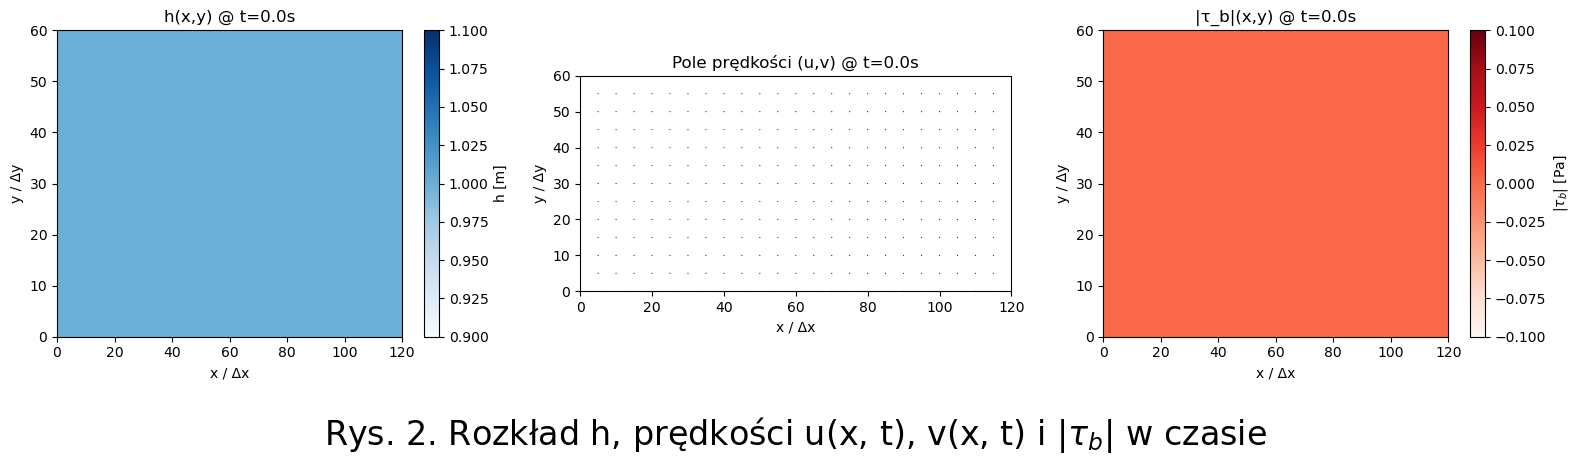

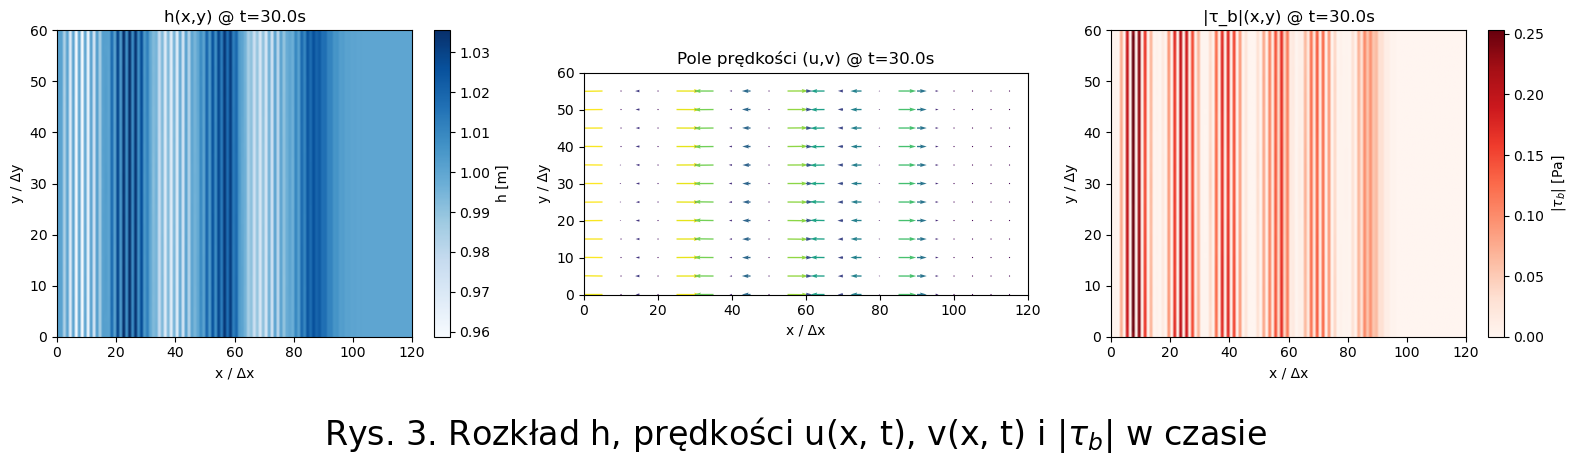

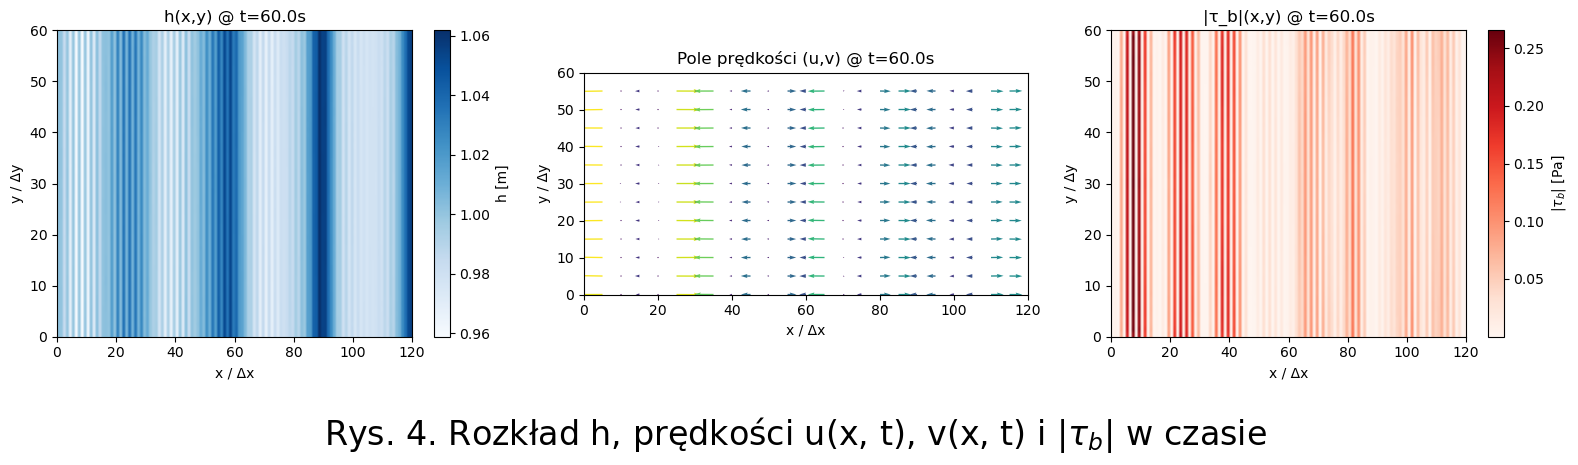

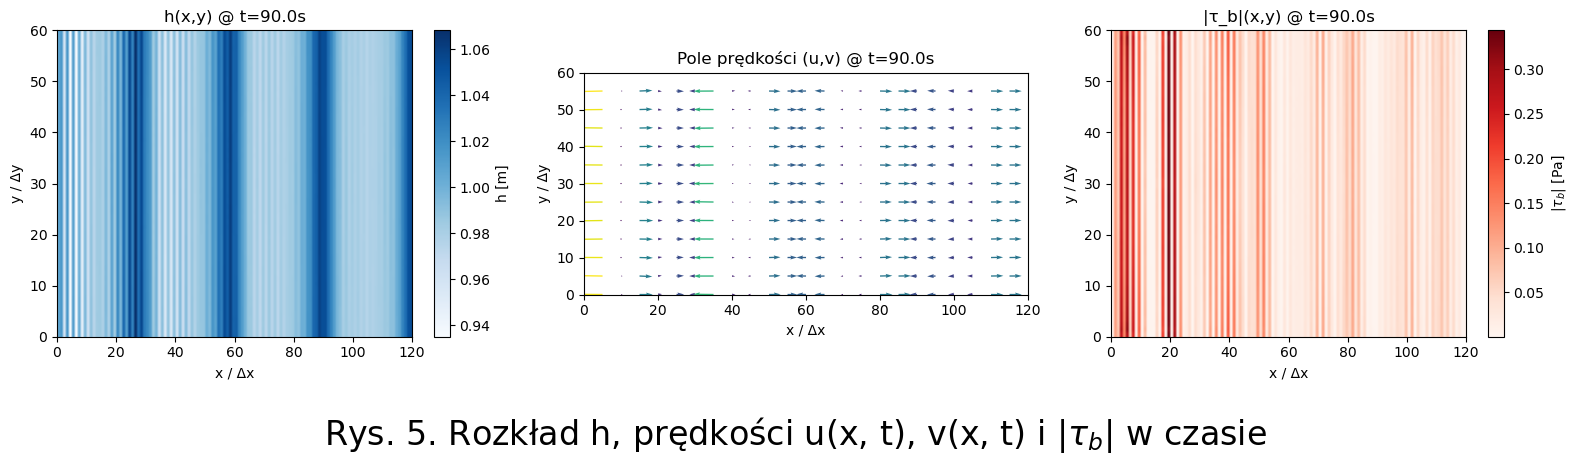

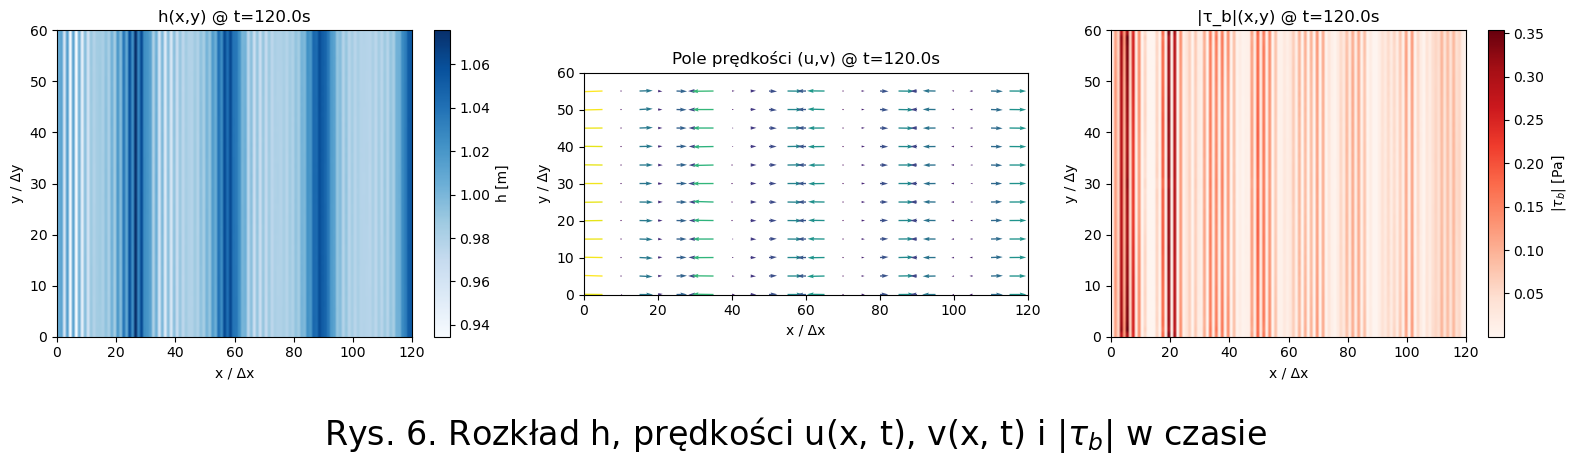

In [19]:
def plot_fields_complete(frame):
    h_k = h_series[frame]
    uh_k = uh_series[frame]
    vh_k = vh_series[frame]
    
    u_k = np.zeros_like(h_k)
    v_k = np.zeros_like(h_k)
    mask = h_k > 1e-7
    u_k[mask] = uh_k[mask] / h_k[mask]
    v_k[mask] = vh_k[mask] / h_k[mask]
    
    _, _, tau_mag = compute_tau_bottom(h_k, uh_k, vh_k, n_manning=n_ex, g=g, rho=rho)
    
    fig, axes = pyplot.subplots(1, 3, figsize=(16, 4))
    
    im1 = axes[0].imshow(h_k.T, origin='lower', cmap='Blues', aspect='auto', 
                          extent=[0, grid[0], 0, grid[1]])
    axes[0].set_title(f"h(x,y) @ t={frame*outfreq*dt:.1f}s")
    axes[0].set_xlabel("x / Δx")
    axes[0].set_ylabel("y / Δy")
    pyplot.colorbar(im1, ax=axes[0], label="h [m]")
    
    skip = 5
    X, Y = np.meshgrid(np.arange(0, grid[0], skip), np.arange(0, grid[1], skip))
    U_sub = u_k[::skip, ::skip].T
    V_sub = v_k[::skip, ::skip].T
    speed = np.sqrt(U_sub**2 + V_sub**2)
    
    axes[1].quiver(X, Y, U_sub, V_sub, speed, cmap='viridis', scale=2, width=0.003)
    axes[1].set_title(f"Pole prędkości (u,v) @ t={frame*outfreq*dt:.1f}s")
    axes[1].set_xlabel("x / Δx")
    axes[1].set_ylabel("y / Δy")
    axes[1].set_aspect('equal')
    axes[1].set_xlim(0, grid[0])
    axes[1].set_ylim(0, grid[1])
    
    im3 = axes[2].imshow(tau_mag.T, origin='lower', cmap='Reds', aspect='auto', 
                          extent=[0, grid[0], 0, grid[1]])
    axes[2].set_title(f"|τ_b|(x,y) @ t={frame*outfreq*dt:.1f}s")
    axes[2].set_xlabel("x / Δx")
    axes[2].set_ylabel("y / Δy")
    pyplot.colorbar(im3, ax=axes[2], label=r"$|\tau_b|$ [Pa]")
    
    pyplot.tight_layout()
    return fig

for idx, k in enumerate([0, nframes//4, nframes//2, 3*nframes//4, nframes-1]):
    fig = plot_fields_complete(k)
    fig.savefig(f"fields_complete_frame_{k}.pdf", bbox_inches="tight")
    fig.text(
    0.5, -0.05,
    fr"Rys. {idx + 2}. Rozkład h, prędkości u(x, t), v(x, t) i |$\tau_{{b}}$| w czasie",
    ha="center", va="top",
    fontsize = 24
)

# Wnioski

Amplituda ma silny, nieliniowy wpływ na naprężenie przydenne, przjście z $A$ = 0.05 m do $A$ = 0.15 m daje wzrost maksymalnego $\tau_{b}$ dla szorstkiego dna o rząd wielkości.

Zagęszczenie siatki nie wpływa na rezultaty, natomiast zmniejszenie kroku czasowego istotnie oddziałuje na uzyskane wyniki, maksymalne naprężenie jest większe o wartość około 15\%. W celu osiągnięcia większej wiarygodności oceny wartości uzyskanych naprężeń, należałoby zmniejszać krok czasowy.

Maksymalne naprężenia przydenne w płytkiej wodzie są zdominowane przez kombinację dużej amplitudy fali i wysokiej szorstkości dna; w takim układzie wartości $|\tau_{b}|$ łatwo przekraczają progi erozji, podczas gdy dla małej amplitudy i gładkiego mułu pozostają stosunkowo niewielkie.

In [20]:
# def plot_3d(frame, *, zlim=(0.8, 1.2)):
#     h_k = h_series[frame]
#     xi, yi = np.indices(h_k.shape)
#     fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))
#     ax.plot_wireframe(xi+.5, yi+.5, h_k, color='blue', linewidth=.5)
#     ax.set(zlim=zlim, proj_type='ortho', 
#            title=f"h(x,y), frame={frame}, t={frame*outfreq*dt:.1f}s", zlabel=r"$h$ [m]")
#     for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
#         axis.pane.fill = False
#         axis.pane.set_edgecolor('black')
#         axis.pane.set_alpha(1)
#     ax.set_xlabel("x / Δx")
#     ax.set_ylabel("y / Δy")
#     return fig

# show_anim(plot_3d, range(len(h_series)))